In [1]:
import math
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import random as rd

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import utils
import utils_cl

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook
%load_ext autoreload

In [2]:
summary_df3 = pd.read_csv("dataset/weekly_applied_fraud_milestones_2.csv", index_col=0)
summary_df3['START_WEEKDAY'] = pd.to_datetime(summary_df3['START_WEEKDAY'])

In [3]:
def get_start_week(str_date):
    return pd.Timestamp(str_date).to_period('W').start_time
summary_df3 = summary_df3[summary_df3['START_WEEKDAY'] < get_start_week('2017-6-1')]
summary_df3 = summary_df3[summary_df3['START_WEEKDAY'] > get_start_week('2017-5-1')]

In [4]:
print(summary_df3.shape)
summary_df3.head()

(3173, 31)


,MA_DIEMDO,START_WEEKDAY,TIME_1,TIME_2,TIME_3,TIME_4,TIME_5,TIME_6,TIME_7,TIME_8,...,TIME_20,TIME_21,TIME_22,TIME_23,TIME_24,TIME_25,TIME_26,TIME_27,TIME_28,IS_FRAUD
18,PP01000100340001,2017-05-08,1.157883,0.588974,1.164815,1.023479,1.200339,0.573871,1.027914,0.999274,...,0.597839,1.164905,0.534112,0.833094,1.149478,0.931447,0.564631,0.761258,0.931969,False
19,PP01000100340001,2017-05-15,1.392151,0.826667,1.143039,1.175271,0.825947,0.825947,1.012323,0.796765,...,0.862009,1.168843,0.457118,1.035191,0.833750,1.530875,0.445014,0.940861,1.094563,False
20,PP01000100340001,2017-05-22,1.468167,0.634809,1.046122,0.887866,1.430181,0.607775,2.036637,1.308963,...,0.989442,0.931850,0.341223,0.921828,1.196837,1.015651,0.333157,1.059505,0.660510,False
82,PP01000101145001,2017-05-08,2.926942,2.119306,2.744577,2.422946,2.617524,1.730967,3.891709,2.967755,...,2.519560,3.156600,1.889362,2.230960,3.231066,3.274836,1.997707,1.681125,1.183591,False
83,PP01000101145001,2017-05-15,2.468523,2.006626,3.275372,2.856537,2.513691,2.513691,2.990469,2.336749,...,1.628081,2.409782,1.607956,2.264891,1.240146,2.964554,1.687241,1.734562,1.552213,False


## Clustering

In [5]:
# Scale Data
summary_df3 = summary_df3.sort_values(by=["IS_FRAUD"])
normal_df = summary_df3[summary_df3['IS_FRAUD'] == False]
fraud_df = summary_df3[summary_df3['IS_FRAUD'] == True]

In [6]:
print("Normal : ", normal_df.shape[0])
print("Fraud : ", fraud_df.shape[0])

Normal :  3060
Fraud :  113


In [7]:
X = summary_df3.iloc[:, 2:-1].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

#X_normalized = normalize(X_scaled, axis=1)
#X_normalized = pd.DataFrame(X_normalized)

X_normalized = X_scaled

n_normal = normal_df.shape[0]
X_normal = X_normalized.iloc[:n_normal, :]
X_fraud = X_normalized.iloc[n_normal:, :]

In [8]:
# Split Normal data into Train & Test set
X_normal_train = X_normal.sample(frac = 0.5, random_state = 0)
X_normal_test = X_normal.drop(X_normal_train.index)

In [10]:
from dtaidistance import dtw as dtw
import utils_cl

p1 = np.random.normal(0, 0.1, 1000)
p2 = np.random.normal(0, 0.1, 1000)

utils_cl.distance_DTW(p1, p2)

2.1568202718779625

In [48]:
rd.randint(100)

TypeError: randint() missing 1 required positional argument: 'b'

In [12]:
from sklearn.cluster import KMeans

distance_used = utils_cl.distance_ED
cluster_number  = 3
n_iters = 500

km = utils_cl.KM(
    n_clusters=cluster_number, init='random',
    n_init=10, max_iter=n_iters, 
    tol=1e-04, random_state=200
)

y_km = km.fit_predict(X_normal_train)
centroids = km.cluster_centers_


KeyboardInterrupt: 

In [ ]:
Z

In [98]:
dict_DC = {}
for i in range(cluster_number):
    dict_DC[i+1] = []
    
for i, j in enumerate(y_km):
    dict_DC[j+1].append(distance_used(centroids[j], X_normal_train.iloc[i, :]))

<IPython.core.display.Javascript object>


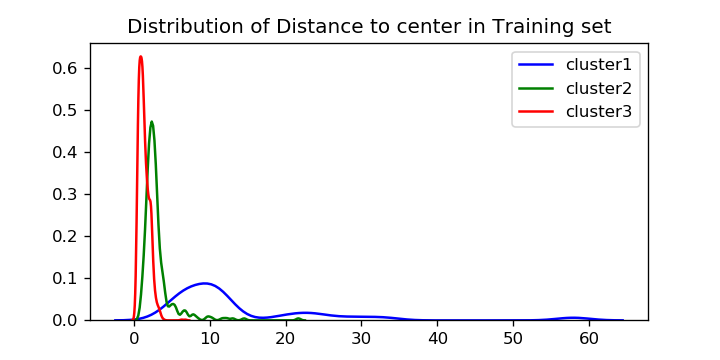

In [99]:
def distribution_plotting(cluster_number, is_print_individual = False):
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    if is_print_individual : 
        for i in range(cluster_number):
            plt.figure(figsize = (4, 2), dpi = 120)
            sns.distplot(dict_DC[i+1])
            plt.title("Distribution of Distance to Center"  + str(i+1))
        
    plt.figure(figsize = (6, 3), dpi = 120)
    for i in range(cluster_number):
        sns.kdeplot(dict_DC[i+1], label="cluster" + str(i+1), color = colors[i])
    plt.legend();
    plt.title("Distribution of Distance to center in Training set")
distribution_plotting(cluster_number, False)


In [101]:
average_radius = []
for j in range(cluster_number):
    average_radius.append(sum(dict_DC[j+1])/len(dict_DC[j+1]))

In [102]:
max_radius = []
for j in range(cluster_number):
    max_radius.append(max(dict_DC[j+1]))

In [103]:
quantile_radius = []
percentile = 0.7
for j in range(cluster_number):
    quantile_radius.append(pd.DataFrame(dict_DC[j+1]).quantile(percentile, axis = 0)[0])

In [104]:
print("average_radius :",  average_radius)
print("max_radius :",  max_radius)
print("quantile_radius :",  quantile_radius)

average_radius : [13.856115242322698, 3.0354204805125873, 1.3437910074511128]
max_radius : [57.93174473845769, 21.682889761167495, 6.754750054051535]
quantile_radius : [11.560948245561471, 2.958756958790418, 1.6285590563626784]


In [105]:
# Predicting 1
def test_mdd_fraud(test_mdd, thresh_hold_KM = 1.0):
    # ED_test2c        : distance from test_mdd to each center
    # distance_cent_th : cluster_radius

    ED_test2c = [distance_used(test_mdd, _cent) for _cent in centroids ]
    distance_cent_th = [_dis*thresh_hold_KM for _dis in quantile_radius]
    result_is_fraud = [ a < b for (a,b) in zip(distance_cent_th, ED_test2c)]
    return result_is_fraud


def prediction_result(test_set, thresh_KM = 1.0, cluster_abnormal = []):
    total_correct = 0
    N = test_set.shape[0]
    test_wrong = [0]*(cluster_number - len(cluster_abnormal))
    for i in range(N):
        try:
            test_mdd_i = test_set.iloc[i, :]
        except :
            print("Fail - ", i)
        test_mdd_fraud_res = test_mdd_fraud(test_mdd_i, thresh_KM)
        for i, j in enumerate(cluster_abnormal):
            del test_mdd_fraud_res[j-1-i]
        if sum(test_mdd_fraud_res) == (cluster_number - len(cluster_abnormal)) :
            total_correct += 1
        else :
            test_wrong = [ a + b for (a,b) in zip(test_wrong, test_mdd_fraud(test_mdd_i, thresh_KM))]
    print("Total fraud predicted      : ", total_correct )
    print("Total test samples         : ", N)
    print(total_correct/N)
    return test_wrong

In [106]:
# Predicting 2
def test_mdd_fraud_2(test_mdd, thresh_KM):
    ED_test2c = [distance_used(test_mdd, _cent) for _cent in centroids]
    distance_nearest = min(ED_test2c)
    cluster_nearest = ED_test2c.index(distance_nearest) + 1
    is_fraud = (distance_nearest > quantile_radius[cluster_nearest-1] * thresh_KM)
    return is_fraud

def prediction_result_2(test_set, thresh_KM = 1.0):
    total_fraud = 0
    N = test_set.shape[0]
    for i in range(N):
        test_mdd_i = test_set.iloc[i, :]
        test_mdd_fraud_res = test_mdd_fraud_2(test_mdd_i, thresh_KM)
        if test_mdd_fraud_res:
            total_fraud += 1
    print("Total fraud predicted      : ", total_fraud )
    print("Total test samples         : ", N)
    print(total_fraud/N)
    return 

In [107]:
thresh_KM = 1

test_set_fraud = X_fraud

cluster_abnormal = []

test_wrong = prediction_result_2(test_set_fraud, thresh_KM)

Total fraud predicted      :  69
Total test samples         :  113
0.6106194690265486


In [108]:
thresh_KM = 1

test_set_normal = X_normal_test

cluster_abnormal = []

test_wrong = prediction_result_2(test_set_normal, thresh_KM)

Total fraud predicted      :  519
Total test samples         :  1530
0.3392156862745098


## .Pred 2


In [21]:
# Clustering
pca = PCA(n_components=3)
X_principal = pca.fit_transform(X_normalized)

In [62]:
from sklearn.cluster import DBSCAN
# DBSCAN
eps = 0.5
min_samples = 3
labels_1 = utils_cl._DBSCAN(X_principal, eps, min_samples)

In [63]:
from collections import Counter
c = Counter(labels_1) 
print(c)

Counter({0: 2918, -1: 162, 2: 17, 4: 5, 8: 5, 10: 4, 9: 4, 11: 4, 1: 3, 3: 3, 5: 3, 6: 3, 7: 3, 12: 3})


In [64]:
summary_df3.shape

(3137, 31)

In [65]:
labels_1

array([ 0,  0, -1, ...,  0,  0, -1], dtype=int64)

In [66]:
count_fr = 0
for i, j in enumerate(labels_1) :
    if (j == -1) and (summary_df3.iloc[i, :]['IS_FRAUD'] == True):
        count_fr += 1
        

In [67]:
count_fr

17

In [58]:
count_i

150

In [56]:
summary_df3.iloc[-2, :]['IS_FRAUD']

True

In [68]:
1-1 == 0

True